# 1. Imports

In [107]:
import math
import datetime
import inflection
import pandas  as pd
import numpy   as np
import seaborn as sns
from boruta import BorutaPy
from scipy import stats as ss
from tabulate import tabulate
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

# 2. Helper Functions

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1) 
    rcorr = r - (r-1)**2 / (n-1) 

    return float(np.sqrt( (chi2corr/n) / ( min( kcorr - 1, rcorr - 1 ) ) ))

# 3. Loading Data

In [4]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

In [5]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 4. Data description

## 4.1 Rename Columns

In [6]:
df1 = df_raw.copy()
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
            'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_cols = list( map( snakecase, old_cols ) )

df1.columns = new_cols

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 4.2 Data Dimension

In [9]:
df1.shape

(1017209, 18)

## 4.3 Data types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 4.4 Check NAs

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 4.5 Fillout NA

In [12]:
# competition_distance
# assigns a huge number to the distance because it's like there's no competition
df1['competition_distance'] = (df1['competition_distance']
                               .apply(lambda x: 2000000.0 if math.isnan(x) 
                                      else x))

# competition_open_since_month

df1['competition_open_since_month'] = (df1.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
    else x['competition_open_since_month'], axis=1))

# competition_open_since_year

df1['competition_open_since_year'] = (df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
    else x['competition_open_since_year'], axis=1))
                   
# promo2_since_week

df1['promo2_since_week'] = (df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
    else x['promo2_since_week'], axis=1))

# promo2_since_year

df1['promo2_since_year'] = (df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
    else x['promo2_since_year'], axis=1))

In [13]:
# promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0 )

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [14]:
df1['is_promo'] = (df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in str(x['promo_interval']).split(',') else 0, axis=1))

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week                    0
promo2_since_year                    0
promo_interval                  508031
month_map                            0
is_promo                             0
dtype: int64

In [16]:
df1.sample(5).T

,853072,52434,856841,975565,149931
store,883,30,192,726,522
day_of_week,2,7,5,4,4
date,2013-05-28 00:00:00,2015-06-14 00:00:00,2013-05-24 00:00:00,2013-02-07 00:00:00,2015-03-19 00:00:00
sales,6074,0,6434,11447,8850
customers,615,0,517,1072,656
open,1,0,1,1,1
promo,1,0,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,1,1,0
store_type,a,a,d,a,d


## 4.6 Change Types

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 4.7 Descriptive Statistical

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 4.7.1 Numerical Attributes

In [20]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [21]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Felipe\AppData\Local\Temp\ipykernel_4980\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

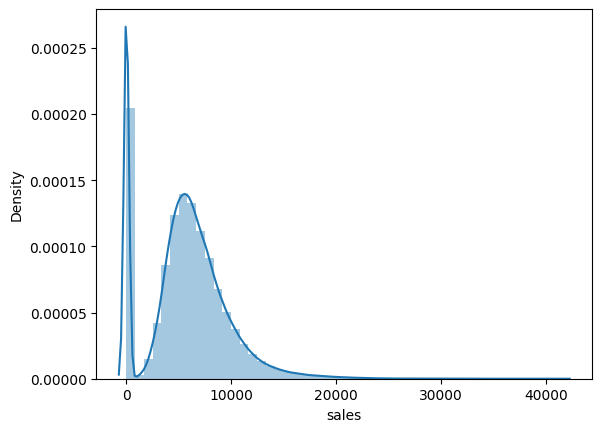

In [22]:
sns.distplot(df1['sales'])

C:\Users\Felipe\AppData\Local\Temp\ipykernel_4980\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<Axes: xlabel='competition_distance', ylabel='Density'>

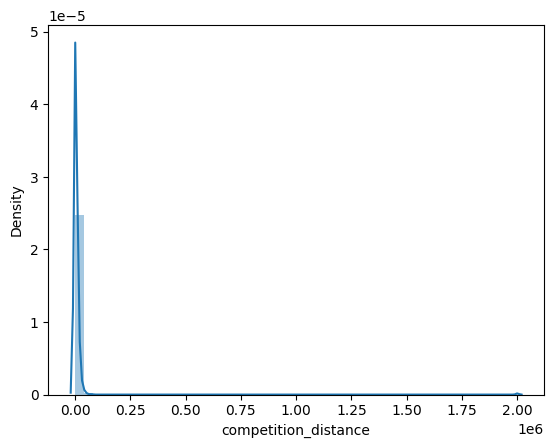

In [23]:
sns.distplot(df1['competition_distance'])

### 4.7.2 Categorical Attributes

In [24]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='state_holiday', ylabel='sales'>

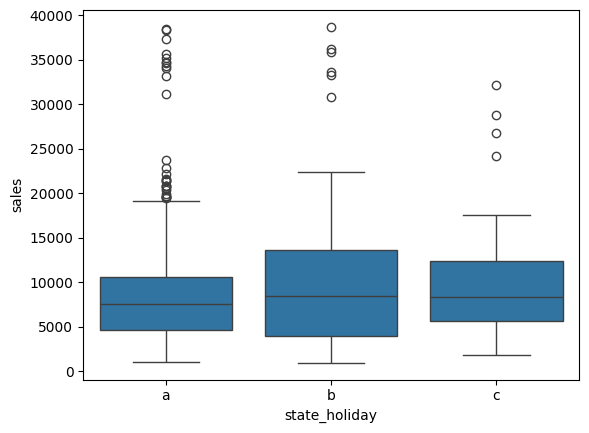

In [25]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)]

sns.boxplot(x='state_holiday', y='sales', data=aux1)

<Axes: xlabel='store_type', ylabel='sales'>

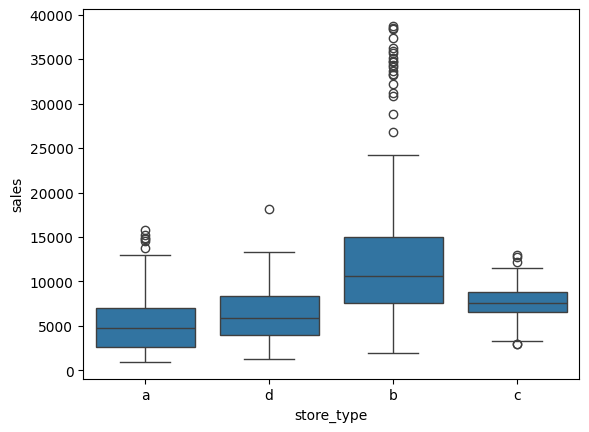

In [26]:
sns.boxplot(x='store_type', y='sales', data=aux1)

<Axes: xlabel='assortment', ylabel='sales'>

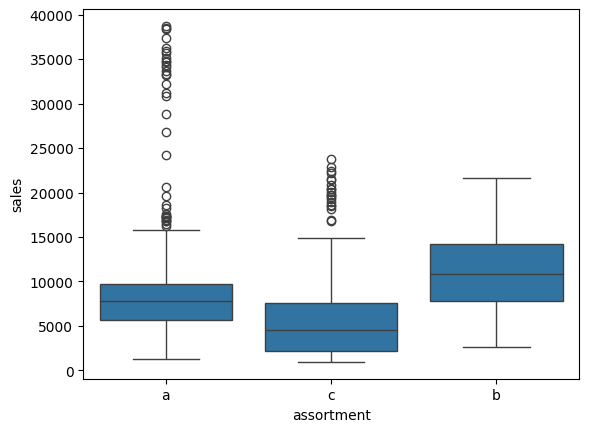

In [27]:
sns.boxplot(x='assortment', y='sales', data=aux1)

# 5. Feature Engineering

In [28]:
df2 = df1.copy()

### 5.1 Hypothesis mind map

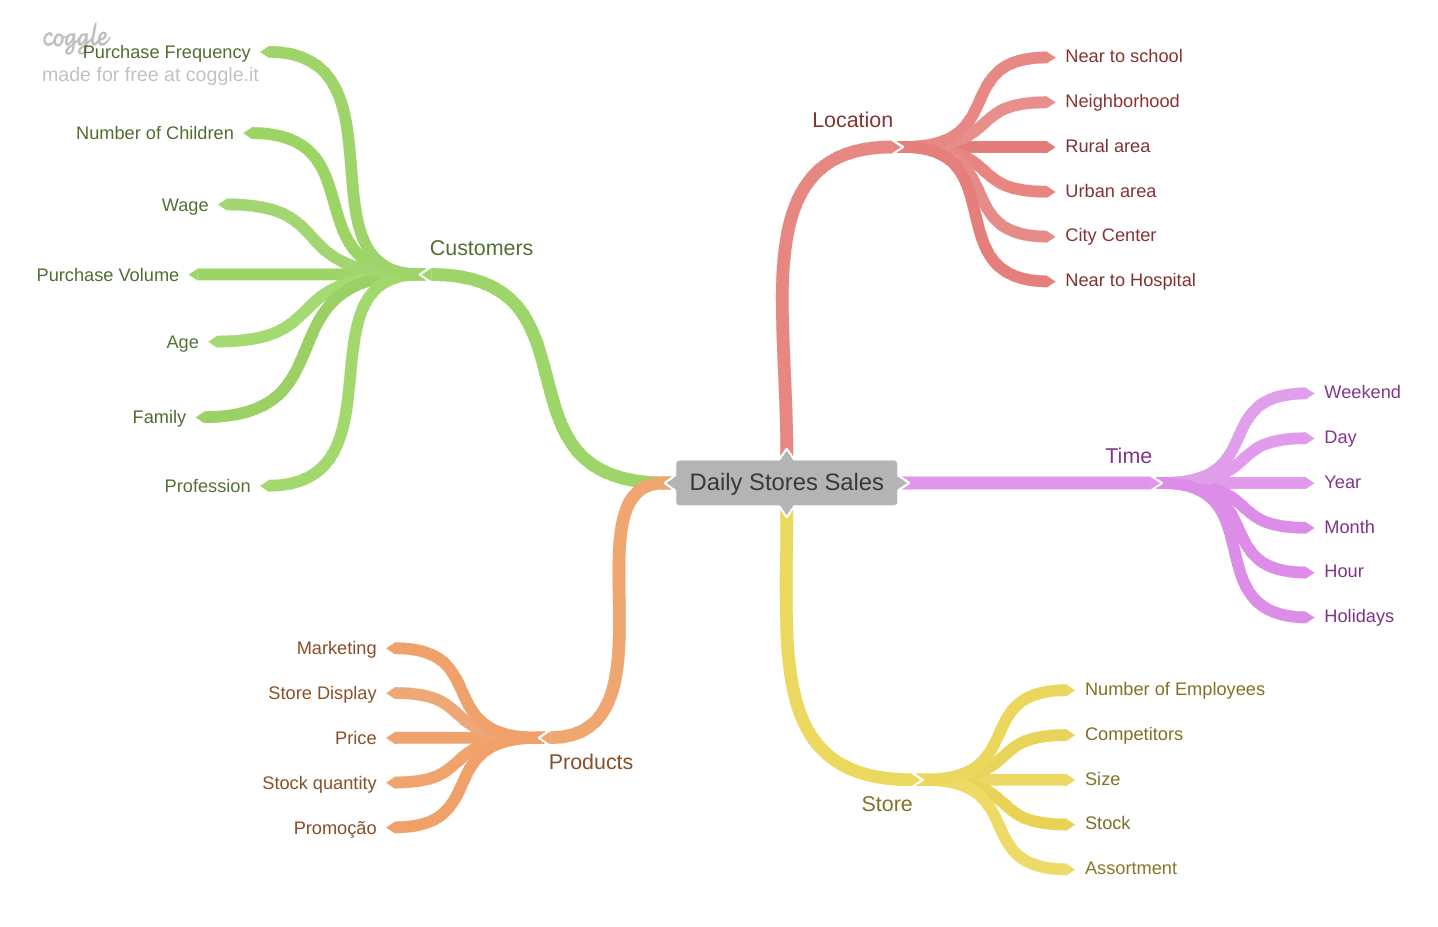

In [29]:
Image('img/mind_map.png')

### 5.2 Creation of hypotheses

#### 5.2.1 Store hypotheses

**1.** Stores with more employees should sell more

**2.** stores with more inventory should sell more

**3.** Smaller stores should sell less

**4.** Stores with a larger assortment should sell more

**5.** Stores with closer competitors should sell less

**6.** Stores with competitors for longer should sell more

#### 5.2.2 Product hypotheses

**1.** Stores that invest more in marketing should sell more

**2.** Stores that display more products should sell more

**3.** Stores with cheaper products should sell more

**4.** Stores with active promotions for longer should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

#### 5.2.3 Time hypotheses

**1.** Stores should sell more over the years

**2.** Stores open at Christmas should sell more

**3.** Stores should sell more in the second half of the year

**4.** Stores should sell more after the 10th of each month

**5.** Stores should sell less on weekends

**6.** Stores should sell less during school holidays

### 5.3 Final list of hypotheses

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with competitors for longer should sell more

**4.** Stores with active promotions for longer should sell more

**5.** Stores with more promotion days should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores should sell more over the years

**8.** Stores open at Christmas should sell more

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

### 5.4 Features

In [30]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


In [31]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] ) /30 ).apply( lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))

df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days).astype(int)


In [32]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [34]:
df2['year'] = df2['year'].astype('int64')
df2['month'] = df2['month'].astype('int64')
df2['day'] = df2['day'].astype('int64')
df2['week_of_year'] = df2['week_of_year'].astype('int64')

In [35]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# 6. Variable Filtering

In [36]:
df3 = df2.copy()

## 6.1 Filtering Rows

In [37]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 6.2 Column Selection

In [38]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

In [39]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 7. Exploratory Data Analysis

In [40]:
df4 = df3.copy()

## 7.1 Univariate Analysis

### 7.1.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

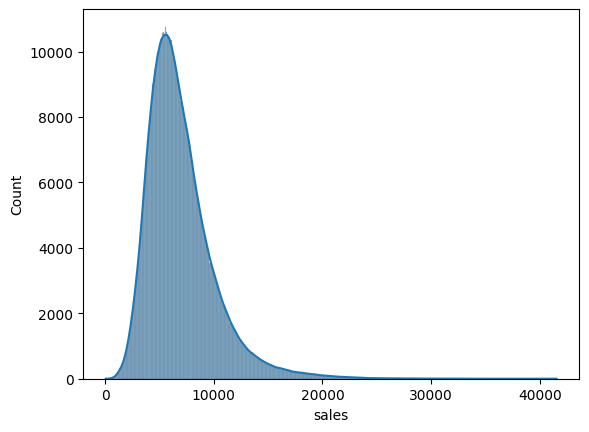

In [41]:
sns.histplot(df4['sales'], kde=True)

### 7.1.2 Numerical Variable

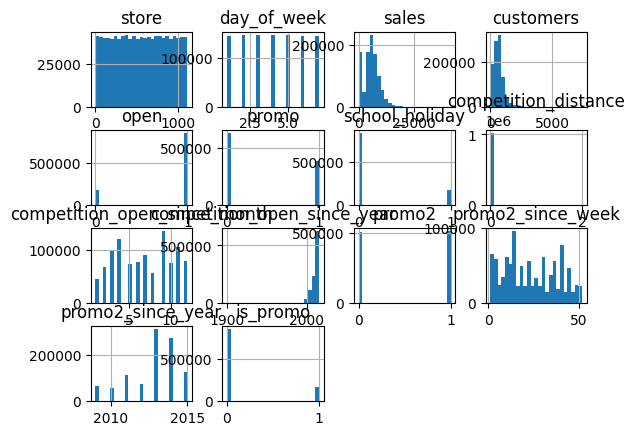

In [42]:
num_attributes.hist(bins=25);

### 7.1.3 Categorical Variable

In [43]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

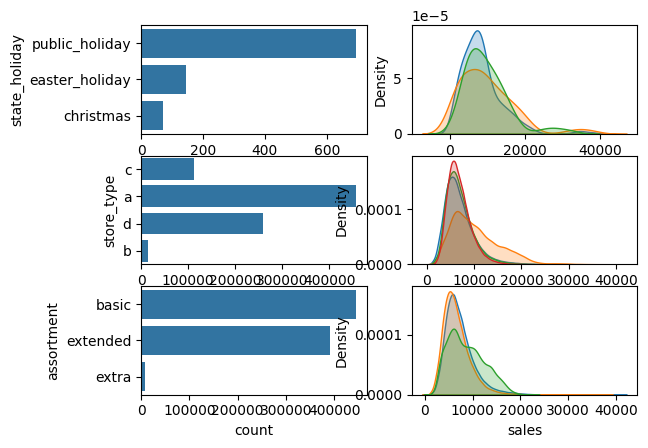

In [44]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)

## 7.2 Bivariate Analysis

### **H1.** Stores with a larger assortment should sell more

#### **False hypothesis**: Stores with a larger assortment sell less

<Axes: xlabel='year_week'>

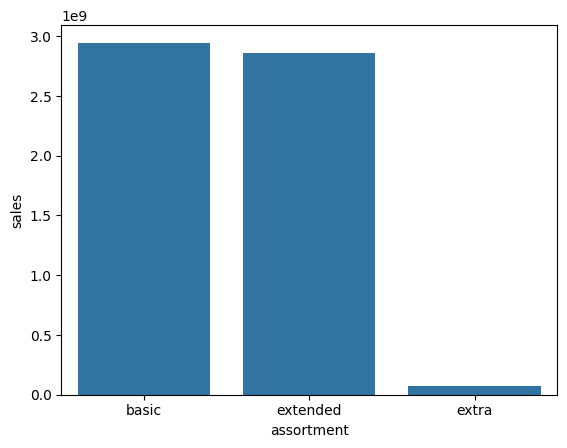

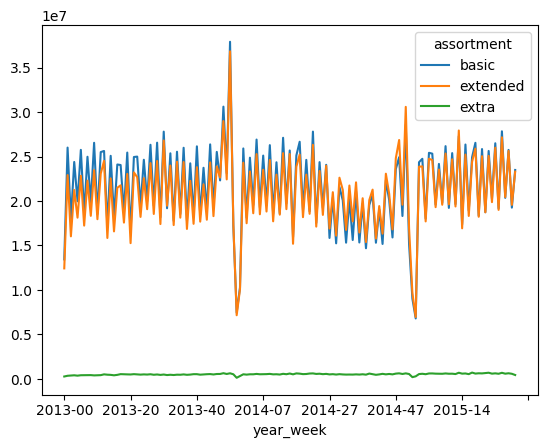

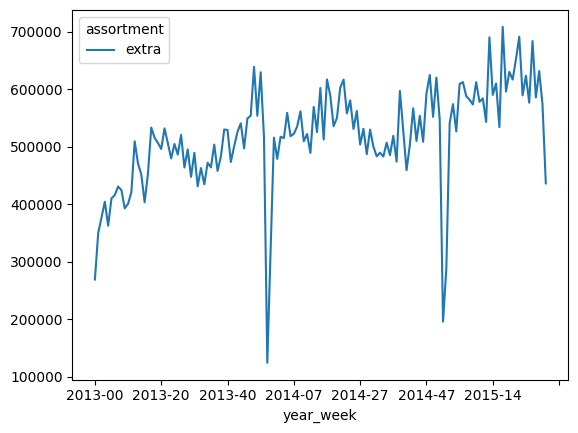

In [45]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### **H2.** Stores with closer competitors should sell less

#### **False hypothesis**: Stores with closer competitors sell more

C:\Users\Felipe\AppData\Local\Temp\ipykernel_4980\2873072625.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


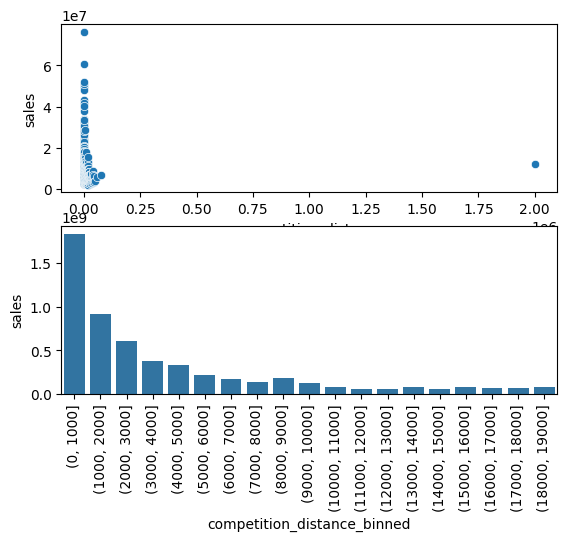

In [46]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(2, 1, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(2, 1, 2)
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.xticks(rotation=90);

### **H3.** Stores with competitors for longer should sell more

#### **False hypothesis**: Stores with newer competitors sell more

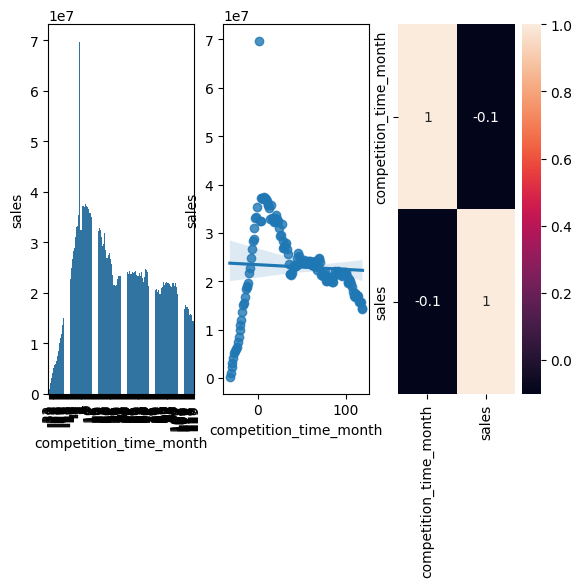

In [47]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Stores with active promotions for longer should sell more

#### **False Hypothesis**: Stores sell regularly until a certain period of active promotion, then sales drop

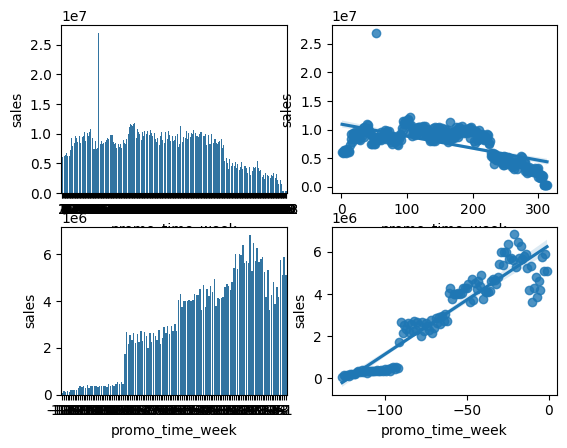

In [48]:
# plt.subplot(1, 3, 1)
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2, 2, 2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2, 2, 3)
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(2, 2, 4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

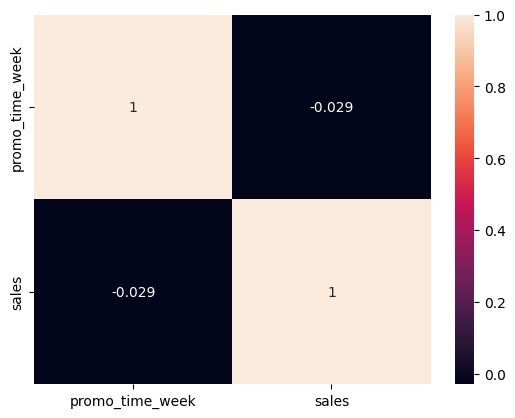

In [49]:
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Stores with more promotion days should sell more</s>

### **H6.** Stores with more consecutive promotions should sell more

#### **False hypothesis**: stores with more consecutive promotions sell less

In [50]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


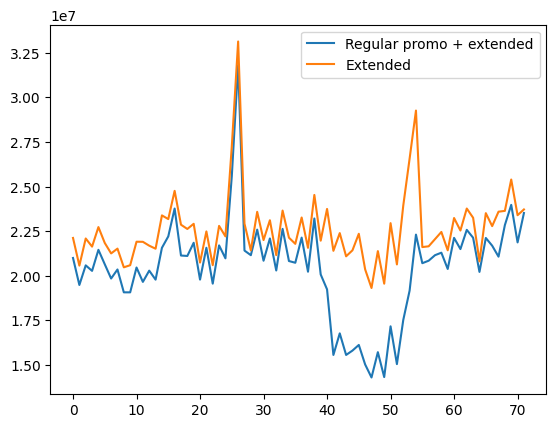

In [51]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Regular promo + extended', 'Extended'])

### **H7.** Stores should sell more over the years

#### **False Hypothesis**: Stores sell less over the years

ValueError: Could not interpret value `year` for `x`. An entry with this name does not appear in `data`.

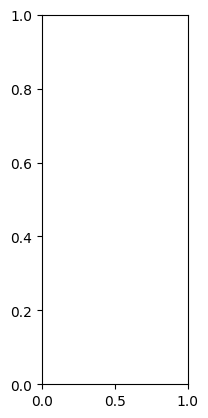

In [52]:
plt.subplot(1, 3, 1)
ax1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1);
u
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H8.** Stores open at Christmas should sell more

#### **False Hypothesis**: Stores open at Christmas sell less

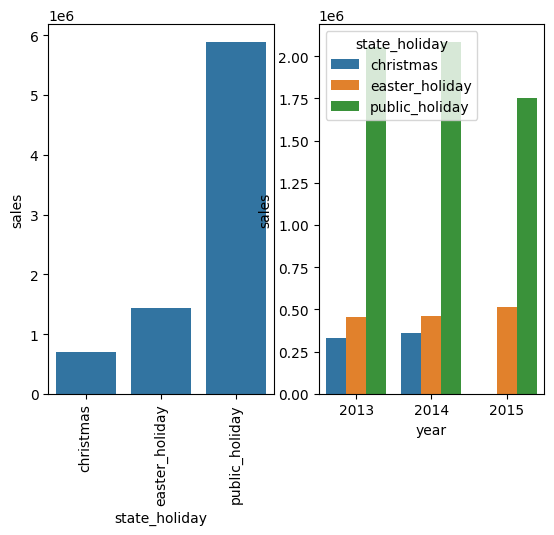

In [57]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);
plt.xticks(rotation=90);


plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H9.** Stores should sell more in the second half of the year

#### **False Hypothesis**: Stores sell less in the second half of the year

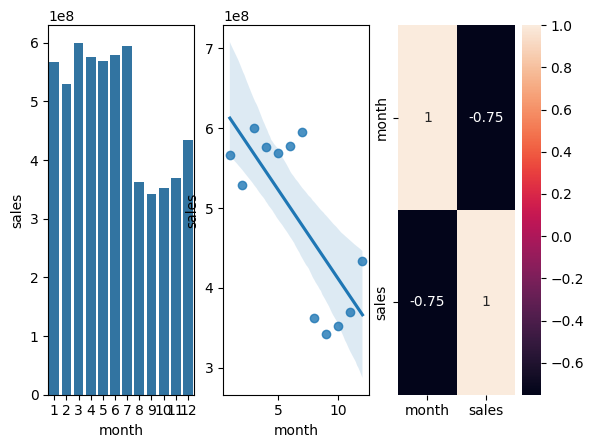

In [66]:
plt.subplot(1, 3, 1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Stores should sell more after the 10th of each month

#### **True hypothesis!**

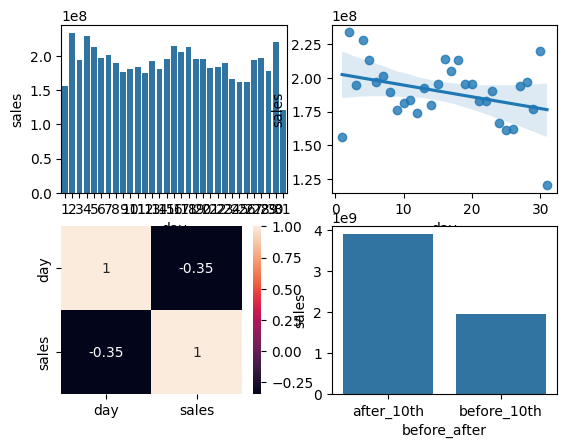

In [68]:
plt.subplot(2, 2, 1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10th' if x <= 10 else 'after_10th')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Stores should sell less on weekends

#### **True Hypothesis!**

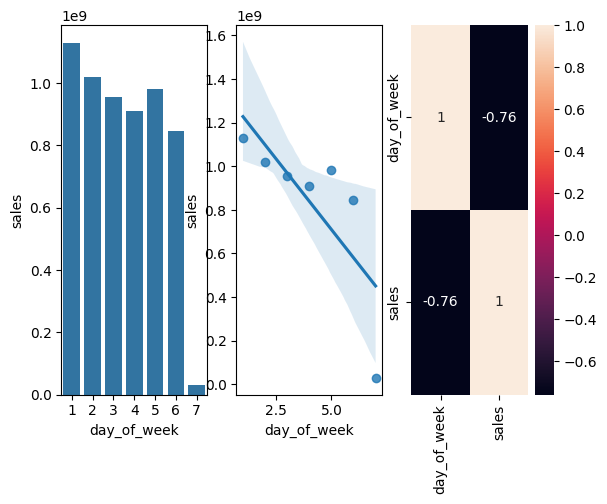

In [71]:
plt.subplot(1, 3, 1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H12.** Stores should sell less during school holidays

#### **True hypothesis**: Stores sell less during school holidays, except in the months of July and August

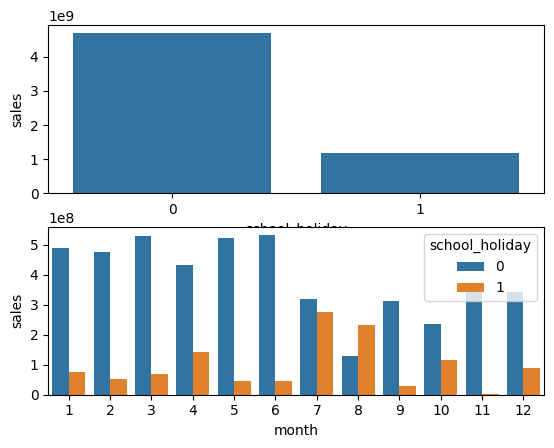

In [74]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

## **Summary**

In [76]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low'],
    ]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 7.3 Multivariate Analysis

### 7.3.1 Numerical Attributes

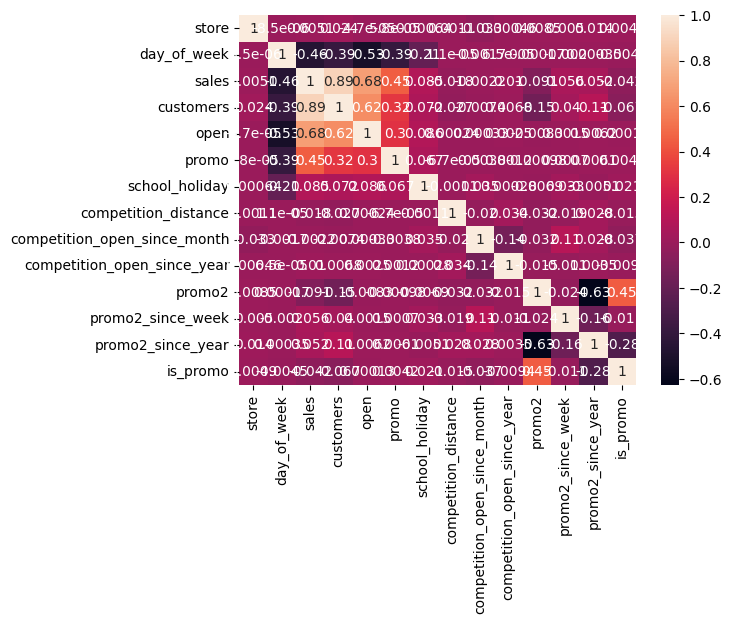

In [77]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 7.3.2 Categorical Attributes

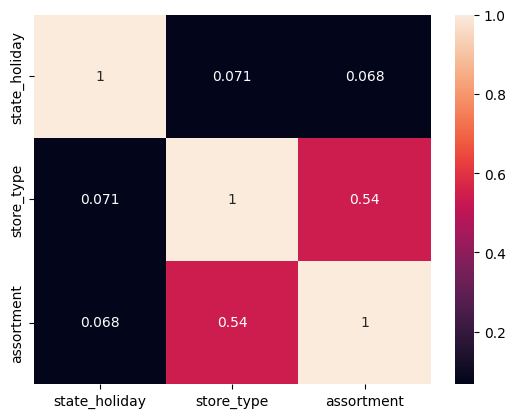

In [106]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 8. Data Preparation

In [89]:
df5 = df4.copy()

## 8.1 Normalization

In [90]:
# There are no normalizable variables. 

## 8.2 Rescaling

In [91]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 8.3 Transformation

### 8.3.1 Enconding

In [92]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 8.3.2 Response Variable Transformation

In [93]:
df5['sales'] = np.log1p( df5['sales'] )

### 8.3.3 Nature Transformation

In [94]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) 
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) ) 

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) 
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) ) 

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) 

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) 
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) ) 

# 9. Feature Selection

In [95]:
df6 = df5.copy()

## 9.1 Split dataframe into training and test

In [96]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [100]:
# Separating the dataframes from the first sale to six weeks before the last sale

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

Timestamp('2015-06-19 00:00:00')

In [104]:
# training dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# test dataset
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'\nTest Min Date: {X_test["date"].min()}')
print(f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 9.2 Boruta as feature selector

In [108]:
# training and test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [109]:
# best features from boruta

cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected features boruta

cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

In [110]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [111]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 9.3 Manual Feature Selection

In [112]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin'
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']


# final features
cols_selected_boruta.extend( feat_to_add )

In [113]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sinweek_of_year_cos',
 'date',
 'sales']